# Generating a Synthetic Healthcare Dataset

This notebook will go through the steps of creating a very simplistic (and therefore unrealistic!) model to generate a synthetic dataset, where each row represents a simulated "person", for illustrative purposes.
The dataset is used in [Chapter 4](../index.md) when discussing the '[Data Analysis](data_analysis.ipynb)' stage of the project lifecycle.

While several sophisticated and powerful tools (e.g. numpyro, Stan) exist for creating models in Python, here we will try to do something simple and understandable using nothing more than `pandas`, and the built-in `random` library.


In [1]:
import random
import datetime
import uuid
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## NHS ID

This one is easy - we'll just make up a unique string using the "uuid" library.   The first 8 characters of the string will be more than enough to essentially guarantee uniqueness among tens of thousands of rows.

In [2]:
def get_nhs_id():
    return str(uuid.uuid4())[:8]

## Generating Age and Gender

One of the main inputs we will use for our generative model is some data on the age profiles of Covid cases and deaths in the UK, taken from this [Public Health England report](https://www.gov.uk/government/publications/covid-19-review-of-disparities-in-risks-and-outcomes)

The data is in Open Document (ods) format - we need to install the `odfpy` package to read it in into pandas in the same way as we would an Excel document.



In [3]:
!pip install odfpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 717.0/717.0 kB 9.0 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
Using legacy 'setup.py install' for odfpy, since package 'wheel' is not installed.
  Running setup.py install for odfpy ... done


The document contains a couple of useful sheets - Figure_1_1 has the age/sex pyramid of lab-confirmed COVID cases, while Figure_1_4 has the equivalent table for deaths following a positive COVID test - we may use this second one later on.

In [4]:
df_cases_age_sex = pd.read_excel("https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/906917/Section_1_-_Age_and_Sex.ods",
                                 sheet_name="Figure_1_1",engine="odf",skiprows=list(range(6))+list(range(16,27)))
# remove the first two rows, dealing with <20 year olds
df_cases_age_sex.drop([0,1], inplace=True)
df_cases_age_sex

,Age group,Males,Females
2,20-29,3361,7470
3,30-39,5240,8868
4,40-49,7020,9646
5,50-59,9476,11083
6,60-69,8907,6731
7,70-79,11350,8074
8,80+,17199,20447


We can just sum the "Males" and "Females" columns to get the total number of each gender and calculate the probability of our simulated person being female, then just generate a random number and compare to that probability.

In [5]:
def get_sex(df):
    prob_female = df["Females"].sum()/(df["Males"].sum()+df["Females"].sum())
    if random.random() < prob_female:
        return "F"
    else:
        return "M"

To generate an age from an age-profile distribution, we can use a trick - by calculating the cumulative fraction over the rows, we can then generate a random number between 0 and 1, and see which row that number falls in, to give us a 10-year age range.  We then pick a random year from that range.

In [6]:
df_cases_age_sex["cumulative_sum_m"] = df_cases_age_sex["Males"].cumsum()/df_cases_age_sex["Males"].sum()
df_cases_age_sex["cumulative_sum_f"] = df_cases_age_sex["Females"].cumsum()/df_cases_age_sex["Females"].sum()
df_cases_age_sex

,Age group,Males,Females,cumulative_sum_m,cumulative_sum_f
2,20-29,3361,7470,0.053730,0.103292
3,30-39,5240,8868,0.137499,0.225916
4,40-49,7020,9646,0.249724,0.359297
5,50-59,9476,11083,0.401212,0.512549
6,60-69,8907,6731,0.543603,0.605622
7,70-79,11350,8074,0.725049,0.717267
8,80+,17199,20447,1.000000,1.000000


In [7]:
def get_age(df, sex):
    # are we looking in the male or female column?
    column_name = "cumulative_sum_f" if sex=="F" else "cumulative_sum_m"
    # generate a random number between 0 and 1
    x = random.random()
    # Highly inefficient way of finding which row of the dataframe
    # has that x value in the cumulative sum range.
    for i in range(len(df)):
        if i == 0 and x < df.iloc[i][column_name]:
            break
        elif x > df.iloc[i-1][column_name] and x < df.iloc[i][column_name]:
            break
    # Now we know the row number "i" - pick an age from that 10-yr range
    #    we have the "age_range" label as a string, e.g. "0-9" - first
    #    split on the dash to get lower and upper bounds
    age_range = df.iloc[i]["Age group"]
    # deal with a couple of special cases
    if age_range == "<10":
        age_range = "0-9"
    elif age_range == "80+":
        age_range="80-89"
    age_range = age_range.split("-")
    # Now use "randint" to choose an age (note that lower and upper bounds
    # are inclusive here)
    age = random.randint(int(age_range[0]), int(age_range[1]))
    return age
    

Let's just check that these functions are doing something sensible - generate 1000 ages and plot them as a histogram:

(array([  0.,   0.,  60.,  70.,  78.,  86.,  49.,  48., 160.,   0.]),
 array([  0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.]),
 <BarContainer object of 10 artists>)

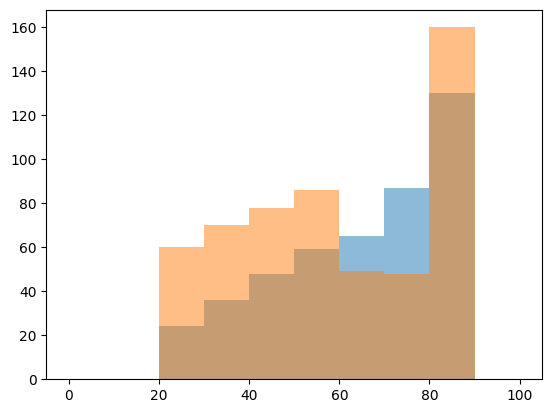

In [8]:
ages = {"M": [], "F":[]}
for _ in range(1000):
    sex = get_sex(df_cases_age_sex)
    ages[sex].append(get_age(df_cases_age_sex, sex))
plt.hist(ages["M"],bins=10,range=(0,100), alpha=0.5, label="M")
plt.hist(ages["F"],bins=10,range=(0,100), alpha=0.5, label="F")

OK, that looks reasonable.  We see the (surprising?) feature that women in their 60s and 70s are less likely than women in their 50s (or men in their 60s and 70s) to be diagnosed with Covid - checking back on the original DataFrame, we see that this is reflected in the numbers.

Let's move on.


## Generating ethnicity

We will use exactly the same approach to generate the ethnicity of our simulated people, using data from the same [Public Health England report](https://www.gov.uk/government/publications/covid-19-review-of-disparities-in-risks-and-outcomes).
Again, we read tables from an .ods file into pandas

In [9]:
df_ethnicity = pd.read_excel("https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/906922/Section_4_-_Ethnicity.ods",
                             sheet_name="Figure_4_1",engine="odf",skiprows=list(range(4))+[55,56])
df_ethnicity.head()

,Ethnicity,Week ending,Deaths
0,White,Up to 07-Mar,324
1,White,14-Mar,1352
2,White,21-Mar,3831
3,White,28-Mar,11158
4,White,04-Apr,18887


*Note* the column here is _incorrectly_ labelled as "deaths", however, it does in fact refer to cases.
Here we have a bit more work to do.  For the moment, we don't care about the date, so we just want to sum over all dates for each ethnic group.

Again, we also calculate the cumulative sum, which will allow us to generate the ethnicity of a simulated patient from this distribution.

In [10]:
df_ethnicity_summary=df_ethnicity.groupby(["Ethnicity"])["Deaths"].sum().to_frame(name = 'sum').reset_index()
# calculate the cumulative sum again
df_ethnicity_summary["cumulative_frac"] = df_ethnicity_summary["sum"].cumsum()/df_ethnicity_summary["sum"].sum()
df_ethnicity_summary

,Ethnicity,sum,cumulative_frac
0,Any other ethnic group,3676,0.028998
1,Asian / Asian British,10815,0.114313
2,Black / Black British,6630,0.166614
3,Mixed / Multiple Ethnic Groups,1351,0.177272
4,White,104294,1.000000


We can now write a function to generate an ethnicity, using the same trick as above with the cumulative fraction:

In [11]:
def get_ethnicity(df):
    x = random.random()
    for i in range(len(df)):
        if i == 0 and x < df.iloc[i]["cumulative_frac"]:
            break
        elif x > df.iloc[i-1]["cumulative_frac"] and x < df.iloc[i]["cumulative_frac"]:
            break
    return df.iloc[i]["Ethnicity"]    

## Week of Admission

There is a table on hospital admission rates for different regions of the country on the PHE document.  We will read this table, but just sum over all regions, and yet again, calculate the cumulative fraction as we go.

In [12]:
df_hospital_admissions = pd.read_excel("https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/906920/Section_2_-_Geography.ods",
                                       sheet_name="Figure_2_3",engine="odf",skiprows=list(range(6))+list(range(74,85)))
df_hospital_admissions["sum"] = df_hospital_admissions.sum(axis=1)
df_hospital_admissions["cumulative_frac"] = df_hospital_admissions["sum"].cumsum()/df_hospital_admissions["sum"].sum()
df_hospital_admissions.head()

/var/folders/cd/zs0x__n52f7c9khtyc73vx1h0000gr/T/ipykernel_60629/880005673.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_hospital_admissions["sum"] = df_hospital_admissions.sum(axis=1)


,Date,East of England,London,Midlands,North East and Yorkshire,North West,South East,South West,sum,cumulative_frac
0,2020-03-15,0.462386,1.375504,0.657536,0.176744,0.252844,0.732170,0.638893,4.296078,0.004329
1,2020-03-16,0.362086,1.009173,0.997340,0.198712,0.439675,0.667369,0.530120,4.204475,0.008566
2,2020-03-17,0.347109,0.886416,1.111063,0.282595,0.573627,0.669402,0.619731,4.489943,0.013090
3,2020-03-18,0.482617,1.211076,1.636191,0.417030,0.759145,0.667377,0.606065,5.779501,0.018914
4,2020-03-19,0.465834,1.192118,1.464436,0.552994,0.749891,0.804439,0.762027,5.991739,0.024952


In [13]:
def get_admission_date(df):
    x = random.random()
    for i in range(len(df)):
        if i == 0 and x < df.iloc[i]["cumulative_frac"]:
            break
        elif x > df.iloc[i-1]["cumulative_frac"] and x < df.iloc[i]["cumulative_frac"]:
            break
    return df.iloc[i]["Date"].to_pydatetime()

## Probability of admission, and of invasive ventilation

We will use yet another table from the PHE report to get the probability of being admitted to hospital, and of getting critical care (here simplified to saying "received invasive ventilation"), as a function of ethnicity.  We also make a correction to the latter probability, based on date of admission - at some point, as medical staff learned more, ventilation became less likely.

In [14]:
df_hospital_care = pd.read_excel("https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/906922/Section_4_-_Ethnicity.ods",
                                 sheet_name="Figure_4_3",engine="odf",skiprows=list(range(5))+list(range(12,25)))
df_hospital_care

,Ethnic group,Critical care (%),Lower level of care (%)
0,White,64.088226,89.050804
1,Black / Black British,7.828518,2.179336
2,Asian / Asian British,17.365641,6.341079
3,Mixed / Multiple ethnic groups,2.889096,0.774583
4,Other ethnic groups,7.828518,1.654195
5,Total admitted,3219.000000,7617.000000


Here, we want to convert the percentages into absolute numbers, so we can combine with `df_ethnicity_summary` to get the probability of being admitted (sum of both "Lower level of care" and "Critical care"), and of being put on ventilation ("Critical care")

In [15]:
df_hospital_care["num_lower"] = (df_hospital_care["Lower level of care (%)"]/100) * df_hospital_care.loc[5]["Lower level of care (%)"]
df_hospital_care["num_critical"] = (df_hospital_care["Critical care (%)"]/100) * df_hospital_care.loc[5]["Critical care (%)"]
df_hospital_care["num_admitted"] = (df_hospital_care["num_lower"] + df_hospital_care["num_critical"]).astype(int)
# Get rid of the "Total admitted" row of this dataframe
df_hospital_care = df_hospital_care.drop(5)
df_hospital_care

,Ethnic group,Critical care (%),Lower level of care (%),num_lower,num_critical,num_admitted
0,White,64.088226,89.050804,6782.999751,2063.000005,8845
1,Black / Black British,7.828518,2.179336,165.999992,252.000007,417
2,Asian / Asian British,17.365641,6.341079,483.000005,558.999972,1041
3,Mixed / Multiple ethnic groups,2.889096,0.774583,58.999999,93.000001,152
4,Other ethnic groups,7.828518,1.654195,126.000002,252.000007,378


So let's:
* Merge with the "df_ethnicity_summary" dataframe on "Ethnicity"
* Add new columns for "prob admitted" and "prob ventilation"

Note that there are some mismatches in the "ethnicity" names - we should rename "Any other ethnic group" in df_ethnicity_summary to "Other ethnic groups", and also fix capitalisation on "Mixed / Multiple ethnic groups"

In [16]:
# fix name mismatches
df_ethnicity_summary.replace(to_replace="Any other ethnic group", value="Other ethnic groups", inplace=True)
df_ethnicity_summary.replace(to_replace="Mixed / Multiple Ethnic Groups", value="Mixed / Multiple ethnic groups", inplace=True)
# harmonize column names
df_hospital_care.rename(columns={"Ethnic group":"Ethnicity"},inplace=True)
# merge dataframes
df_hospital_care = df_hospital_care.merge(df_ethnicity_summary, on="Ethnicity")
# add columns
df_hospital_care["prob_admitted"] = df_hospital_care["num_admitted"]/df_hospital_care["sum"]
df_hospital_care["prob_ventilation"] = df_hospital_care["num_critical"]/df_hospital_care["sum"]
df_hospital_care


,Ethnicity,Critical care (%),Lower level of care (%),num_lower,num_critical,num_admitted,sum,cumulative_frac,prob_admitted,prob_ventilation
0,White,64.088226,89.050804,6782.999751,2063.000005,8845,104294,1.000000,0.084808,0.019781
1,Black / Black British,7.828518,2.179336,165.999992,252.000007,417,6630,0.166614,0.062896,0.038009
2,Asian / Asian British,17.365641,6.341079,483.000005,558.999972,1041,10815,0.114313,0.096255,0.051687
3,Mixed / Multiple ethnic groups,2.889096,0.774583,58.999999,93.000001,152,1351,0.177272,0.112509,0.068838
4,Other ethnic groups,7.828518,1.654195,126.000002,252.000007,378,3676,0.028998,0.102829,0.068553


Let's combine all this to get hospital admission and care data:

In [17]:
def get_hospital_data(df_admission, df_care, ethnicity, change_date="2020-04-15"):
    """
    params
    ======
    df_admission: pandas DataFrame containing admission dates
    df_care: pandas DataFrame containing probabilities of admission and ventilation by ethnicity
    ethnicity: str, the ethnicity of the simulated patient
    change_date: str, ISO date format, date at which ventilation became less likely.
    
    returns
    =======
    (admitted, admission_date, ventilated): tuple of (bool, datetime, bool)
    """
    # did they get admitted?  If not, everything else is moot
    x = random.random()
    prob_admitted = float(df_care[df_care.Ethnicity==ethnicity]["prob_admitted"])
    if x > prob_admitted:
        # they weren't admitted to hospital, so no admission date, and no ventilation
        return False, None, False
    change_date = datetime.datetime.fromisoformat(change_date)
    admission_date = get_admission_date(df_admission)
    prob_ventilation = float(df_care[df_care.Ethnicity==ethnicity]["prob_ventilation"])
    # modify prob_ventilation based on change_date
    if admission_date < change_date:
        prob_ventilation *= 1.2
    else: 
        prob_ventilation *= 0.5
    ventilated = x < prob_ventilation
    return (True, admission_date, ventilated)
    

## Generating other variables


For height and weight, we will assume Gaussian distributions of height and BMI (BMI is height (in m) divided by weight (in kg) squared), with sex-dependent means and standard deviations.
The mean and standard deviations in height are taken from ["restore", here](https://www.restore.ac.uk/srme/www/fac/soc/wie/research-new/srme/modules/mod1/8/index.html) while those for BMI are estimates based on the values provided by [statistica, here](https://www.statista.com/statistics/375886/adult-s-body-mass-index-by-gender-and-age-in-england/).

We then do some purely ad-hoc corrections to these values to account for age.  We estimate that babies are about 0.5m tall on average, with average BMI of 23.
For height, we assume a linear relation between average height and age from the ages 0-16, then flat afterwards, while for BMI we assume a two-sided linear relation between BMI and age, with the maximum value at age 60.

These assumptions and guesses give us means and standard deviations for Gaussians, depending on age and sex.  We can then use `random.gauss` to draw from these Gaussians and get a height and BMI for a simulated person, then use these to calculate weight.

In [18]:
def get_height_weight(age, sex):
    # if sex is given as "null", assign a 50/50 chance to treating  
    # as "M" or "F" for the purpose of height/weight generation
    if sex == "null":
        sex = "F" if random.random() < 0.5 else "M" 
    # assume linear growth from 0.5m to avg between ages of 0 and 16
    avg_height = 1.78 if sex=="M" else 1.63
    std_height = 0.07 if sex=="M" else 0.06
    if age < 16:
        avg_height = 0.5 + (avg_height-0.5)*age/16
    height = random.gauss(avg_height, std_height)
    # BMI tends to peak at age 60 and is similar for men and women.
    # Take _very_ simplified model where we take max_avg_bmi to be 29
    # at age 60, and min_avg_bmi to be 23 at 60 years away from this,
    # and linearly interpolate between
    avg_bmi_max = 29
    avg_bmi_min = 23
    avg_bmi = abs(60-age)*(avg_bmi_max-avg_bmi_min)/60 + avg_bmi_min
    std_bmi = 6.1 if sex=="F" else 4.7
    # truncated Gaussian - it doesn't make sense to have BMI < 13 or > 50
    bmi = 0.0
    while (bmi < 13.5 or bmi > 50.):
        bmi = random.gauss(avg_bmi, std_bmi)
    # calculate weight from height and bmi
    weight = bmi * height*height
    return height, weight
    

## Survival rate

Now we come to the most critical part, and also the one where we are making the most assumptions - the chance for a simulated patient who has a positive COVID test to die.
We will start from a small baseline probability, and increase this based on several factors:
* Age - the chance of dying from COVID increases almost exponentially with age.  Based on CDC figures [here](https://www.cdc.gov/coronavirus/2019-ncov/covid-data/investigations-discovery/hospitalization-death-by-age.html) we estimate that using 20-year-olds as the baseline, the chances of dying with COVID approximately double for every 8 years older.
* BMI - having a BMI over 30 increases the chance of dying
* Sex - Men have a higher chance of dying of COVID than women
* Ethnicity - People of Chinese, Indian, Pakistani, Other Asian, Black Caribbean and Other Black ethnicity had between 10 and 50% higher risk of death when compared to White British - the numbers used here are based on table A1 in [the PHE document](https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/908434/Disparities_in_the_risk_and_outcomes_of_COVID_August_2020_update.pdf)
* We also make some ad-hoc assumptions regarding whether the patient was hospitalised and had intrusive ventilation.   In general we assume that the most seriously ill patients were admitted, and given critical care, and these were most likely to die.  
- For those that were admitted, we apply a small correction to account for the fact that the knowledge in hospitals improved over time - we say 1% relative per day after 15th April

In [19]:
def did_patient_die(age, 
                    height, 
                    weight, 
                    sex, 
                    ethnicity, 
                    admitted, 
                    admission_date, 
                    ventilation, 
                    change_date="2020-04-15", 
                    baseline_prob=0.001):
    """
    Returns: bool, True if patient died, False otherwise
    """
    # modify for age - chance of death doubles every 8 years
    prob = baseline_prob * pow(2, (age - 20)/8.)
    # modify for sex
    prob = prob*1.2 if sex == "M" else prob*0.8
    # modify for BMI - linear relation factor 1.05 per unit of BMI over 23
    BMI = height / weight*weight
    if BMI > 23:
        bmi_factor = 1.05 * (BMI-23)
        prob = prob * bmi_factor
    # modify for ethnicity
    if ethnicity == "Asian / Asian British":
        prob = prob * 1.36
    elif ethnicity == "Black / Black British":
        prob = prob * 1.22
    elif ethnicity == "Mixed / Multiple ethnic groups":
        prob = prob * 1.12
    elif ethnicity == "Other ethnic groups":
        prob = prob * 1.04
    # ad-hoc corrections for whether the patient was 
    # hospitalised, and given ventilation

    if admitted:
        prob *= 2
        if ventilation: # double the risk again
            prob *= 2
    else:
        prob *= 0.65

    # if patient was admitted, account for the fact that care improved after some date
    if admitted:
        if isinstance(admission_date, str):
            admission_date = datetime.datetime.fromisoformat(admission_date)
        t = (admission_date - datetime.datetime.fromisoformat(change_date)).days
        if t > 0:
            prob = prob*(1 - t*0.01)
    # now lets see whether random number 0<x<1 is below prob
    x = random.random()
    return x < prob
    

## Putting it all together

We're now ready to generate some simulated people.  We first get the age, then the sex, then use these to get a height and weight, using the functions defined above.  Each simulated person will be returned as a JSON object, which we can then accumulate into a pandas dataframe.

In [20]:
def generate_person(df_age_sex, df_ethnicity, df_admission, df_care):
    """
    Generate characteristics of a simulated person, and return as JSON
    
    parameter: df: pd.DataFrame, the age and sex profile of cases(including cumulative sum)
    returns: JSON object containing all generated parameters.
    """
    nhs_id = get_nhs_id()
    sex = get_sex(df_age_sex)
    age = get_age(df_age_sex, sex)
    ethnicity = get_ethnicity(df_ethnicity)
    admitted, admission_date, ventilated = get_hospital_data(df_admission, df_care, ethnicity)
    height, weight = get_height_weight(age, sex)
    died = did_patient_die(age, height, weight, sex, ethnicity, admitted, admission_date, ventilated)
    return {
        "nhs_id": nhs_id, 
        "site_id": "UHJ_43643",
        "age": age, 
        "sex": sex, 
        "ethnicity": ethnicity,
        "height": height, 
        "weight": weight,
        "admitted": admitted,
        "admission_date": admission_date,
        "intrusive_ventilation": ventilated,
        "died": died
    }

In [21]:
people = []
for i in range(50000):
    if i % 1000 == 0:
        print("Generating", i)
    people.append(
        generate_person(
            df_cases_age_sex, 
            df_ethnicity_summary, 
            df_hospital_admissions,
            df_hospital_care)
    )

Generating 0
Generating 1000
Generating 2000
Generating 3000
Generating 4000
Generating 5000
Generating 6000
Generating 7000
Generating 8000
Generating 9000
Generating 10000
Generating 11000
Generating 12000
Generating 13000
Generating 14000
Generating 15000
Generating 16000
Generating 17000
Generating 18000
Generating 19000
Generating 20000
Generating 21000
Generating 22000
Generating 23000
Generating 24000
Generating 25000
Generating 26000
Generating 27000
Generating 28000
Generating 29000
Generating 30000
Generating 31000
Generating 32000
Generating 33000
Generating 34000
Generating 35000
Generating 36000
Generating 37000
Generating 38000
Generating 39000
Generating 40000
Generating 41000
Generating 42000
Generating 43000
Generating 44000
Generating 45000
Generating 46000
Generating 47000
Generating 48000
Generating 49000


Now put this list of dicts into a pandas dataframe:

In [22]:
df_people = pd.DataFrame.from_records(people)

In [23]:
df_people.head(20)

,nhs_id,site_id,age,sex,ethnicity,height,weight,admitted,admission_date,intrusive_ventilation,died
0,9ce327c2,UHJ_43643,52,F,White,1.663158,70.109264,False,NaT,False,False
1,14e2597c,UHJ_43643,64,M,White,1.703315,48.303981,False,NaT,False,False
2,a067a181,UHJ_43643,66,M,Asian / Asian British,1.752846,52.052148,False,NaT,False,False
3,5173ad7c,UHJ_43643,53,F,Asian / Asian British,1.635242,82.110462,False,NaT,False,False
4,f5675de6,UHJ_43643,45,M,Asian / Asian British,1.726429,83.635670,False,NaT,False,False
5,54ee8313,UHJ_43643,86,M,White,1.716046,76.303355,False,NaT,False,False
6,e497c42c,UHJ_43643,45,F,Black / Black British,1.484366,69.254585,False,NaT,False,False
7,ce007cce,UHJ_43643,87,M,White,1.872772,87.065439,False,NaT,False,False
8,98a53cda,UHJ_43643,73,M,White,1.811295,127.029391,False,NaT,False,True
9,bbe97839,UHJ_43643,38,F,White,1.605770,64.814217,False,NaT,False,False


Now export this to a CSV file:

In [24]:
df_people.to_csv("covid_patients_syn_data_unbiased.csv")

Quick check on whether the age profile of the people that died looks sensible:

(array([0.000e+00, 0.000e+00, 1.000e+00, 1.000e+01, 3.300e+01, 5.500e+01,
        6.900e+01, 2.440e+02, 1.372e+03, 0.000e+00]),
 array([  0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.]),
 <BarContainer object of 10 artists>)

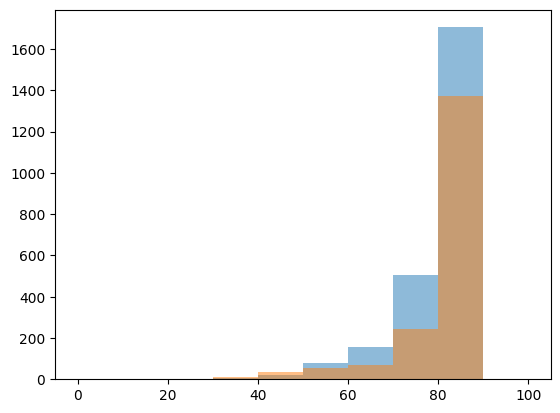

In [25]:
df_died = df_people[df_people.died==True]
ages = {"M": [], "F":[]}
for _ in range(1000):
    ages["M"] = list(df_died[df_died.sex=="M"]["age"])
    ages["F"] = list(df_died[df_died.sex=="F"]["age"])
plt.hist(ages["M"],bins=10,range=(0,100), alpha=0.5, label="M")
plt.hist(ages["F"],bins=10,range=(0,100), alpha=0.5, label="F")

## Adding biases into the dataset

There are a few possible ways that the data can be imperfect.  A simple example is the binary classification of sex into "M" and "F" - some fraction of our simulated patients may be non-binary, or will have not filled in this value.  Let's replace 5% of our "M" and "F" labels with "null".

In [26]:
def add_null_gender(df, null_prob=0.05):
    for irow in range(len(df)):
        if random.random() < 0.05:
            df.at[irow,"sex"] = "null"
    return df

In [27]:
df_people = add_null_gender(df_people)
df_people.head(20)

,nhs_id,site_id,age,sex,ethnicity,height,weight,admitted,admission_date,intrusive_ventilation,died
0,9ce327c2,UHJ_43643,52,F,White,1.663158,70.109264,False,NaT,False,False
1,14e2597c,UHJ_43643,64,M,White,1.703315,48.303981,False,NaT,False,False
2,a067a181,UHJ_43643,66,M,Asian / Asian British,1.752846,52.052148,False,NaT,False,False
3,5173ad7c,UHJ_43643,53,F,Asian / Asian British,1.635242,82.110462,False,NaT,False,False
4,f5675de6,UHJ_43643,45,M,Asian / Asian British,1.726429,83.635670,False,NaT,False,False
5,54ee8313,UHJ_43643,86,M,White,1.716046,76.303355,False,NaT,False,False
6,e497c42c,UHJ_43643,45,F,Black / Black British,1.484366,69.254585,False,NaT,False,False
7,ce007cce,UHJ_43643,87,M,White,1.872772,87.065439,False,NaT,False,False
8,98a53cda,UHJ_43643,73,M,White,1.811295,127.029391,False,NaT,False,True
9,bbe97839,UHJ_43643,38,F,White,1.605770,64.814217,False,NaT,False,False


Another potential bias could be that older people are under-represented in the dataset because they never presented at a hospital - write a function to remove some fraction of people in some age range:

In [28]:
def remove_elderly(df, age_range):
    """
    Remove some fraction (prob_remove) of people in a given age range 
    who weren't admitted to hospital
    
    Parameters
    ==========
    df: pandas DataFrame
    age_range: list of 2 ints, min and max of age range to be removed
    prob_remove (optional): fraction of patients within age range to remove
    """
    query_string = "({} < age < {})& (died==True)".format(age_range[0], age_range[1])
    df = df.drop(df.query(query_string).sample(frac=0.3).index)
    query_string = "({} < age < {})".format(age_range[0], age_range[1])
    df_new = df.drop(df.query(query_string).sample(frac=0.3).index)
    return df_new
            

In [29]:
df_people = remove_elderly(df_people,[75,95])


Data entry errors can also occur - perhaps someone gave their height in feet and inches rather than metres:

In [30]:
index = random.randint(0,len(df_people))
df_people.at[index,"height"] = 5.9

OK, let's output this to a different CSV file, which is what we will use as input for the data analysis task.

In [31]:
df_people = df_people.sort_values("ethnicity", ascending=False)
df_people.to_csv("covid_patients_syn_data.csv")